# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.15KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

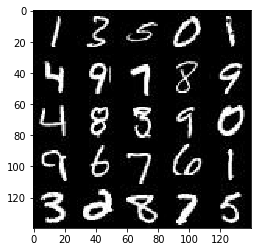

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

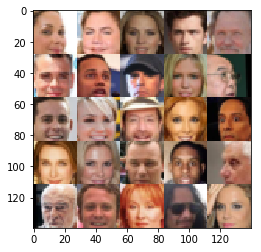

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
def lrelu(x, alpha):
    return tf.maximum(x * alpha, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        # 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 7x7x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 4x4x256
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 7x7x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 14x14x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer=kinit, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_real_out, d_real_logits = discriminator(input_real, alpha=alpha)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True, alpha=alpha)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_out) * (1 - smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels    = tf.ones_like(d_fake_out)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))

    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 0.9307
Epoch 1/2... Discriminator Loss: 0.5399... Generator Loss: 2.0953
Epoch 1/2... Discriminator Loss: 0.4401... Generator Loss: 2.7905
Epoch 1/2... Discriminator Loss: 0.4029... Generator Loss: 3.0503
Epoch 1/2... Discriminator Loss: 0.4994... Generator Loss: 3.9604
Epoch 1/2... Discriminator Loss: 0.3737... Generator Loss: 3.5594
Epoch 1/2... Discriminator Loss: 0.3600... Generator Loss: 3.9961
Epoch 1/2... Discriminator Loss: 0.3674... Generator Loss: 3.9002
Epoch 1/2... Discriminator Loss: 0.4555... Generator Loss: 3.5697
Epoch 1/2... Discriminator Loss: 0.3554... Generator Loss: 4.4600


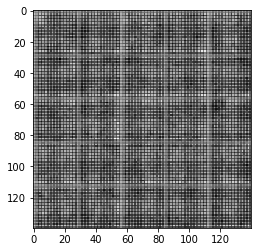

Epoch 1/2... Discriminator Loss: 0.3613... Generator Loss: 4.0855
Epoch 1/2... Discriminator Loss: 0.3781... Generator Loss: 4.0063
Epoch 1/2... Discriminator Loss: 0.3470... Generator Loss: 4.6663
Epoch 1/2... Discriminator Loss: 0.3519... Generator Loss: 4.3303
Epoch 1/2... Discriminator Loss: 0.4887... Generator Loss: 3.6893
Epoch 1/2... Discriminator Loss: 0.4468... Generator Loss: 5.2870
Epoch 1/2... Discriminator Loss: 0.3569... Generator Loss: 4.6084
Epoch 1/2... Discriminator Loss: 0.3507... Generator Loss: 4.4916
Epoch 1/2... Discriminator Loss: 0.3685... Generator Loss: 3.8343
Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 0.7810


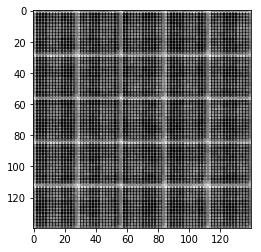

Epoch 1/2... Discriminator Loss: 0.3776... Generator Loss: 4.3541
Epoch 1/2... Discriminator Loss: 0.4169... Generator Loss: 2.9771
Epoch 1/2... Discriminator Loss: 1.0811... Generator Loss: 0.8672
Epoch 1/2... Discriminator Loss: 0.4267... Generator Loss: 3.2217
Epoch 1/2... Discriminator Loss: 0.4527... Generator Loss: 2.5506
Epoch 1/2... Discriminator Loss: 0.7648... Generator Loss: 1.2642
Epoch 1/2... Discriminator Loss: 0.5601... Generator Loss: 1.9895
Epoch 1/2... Discriminator Loss: 0.8447... Generator Loss: 1.2304
Epoch 1/2... Discriminator Loss: 0.5838... Generator Loss: 1.8197
Epoch 1/2... Discriminator Loss: 0.6806... Generator Loss: 2.2392


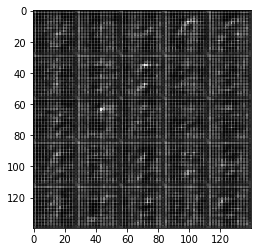

Epoch 1/2... Discriminator Loss: 0.6194... Generator Loss: 1.5796
Epoch 1/2... Discriminator Loss: 0.9953... Generator Loss: 0.8306
Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 4.1296
Epoch 1/2... Discriminator Loss: 0.9356... Generator Loss: 0.9644
Epoch 1/2... Discriminator Loss: 0.7274... Generator Loss: 1.2866
Epoch 1/2... Discriminator Loss: 0.7456... Generator Loss: 1.2814
Epoch 1/2... Discriminator Loss: 0.6481... Generator Loss: 2.2544
Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 3.0385
Epoch 1/2... Discriminator Loss: 1.3507... Generator Loss: 0.5671
Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 0.7678


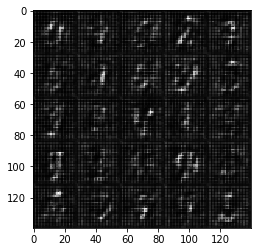

Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 1.1400
Epoch 1/2... Discriminator Loss: 1.7936... Generator Loss: 4.4625
Epoch 1/2... Discriminator Loss: 0.6357... Generator Loss: 1.6324
Epoch 1/2... Discriminator Loss: 0.6247... Generator Loss: 2.4798
Epoch 1/2... Discriminator Loss: 0.6868... Generator Loss: 1.5223
Epoch 1/2... Discriminator Loss: 0.6263... Generator Loss: 2.0503
Epoch 1/2... Discriminator Loss: 0.7264... Generator Loss: 2.6549
Epoch 1/2... Discriminator Loss: 0.7862... Generator Loss: 1.1751
Epoch 1/2... Discriminator Loss: 0.5890... Generator Loss: 2.2379
Epoch 1/2... Discriminator Loss: 0.5502... Generator Loss: 2.1054


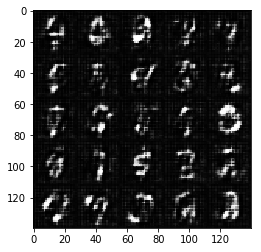

Epoch 1/2... Discriminator Loss: 0.6637... Generator Loss: 1.4800
Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 1.6311
Epoch 1/2... Discriminator Loss: 0.5935... Generator Loss: 2.3333
Epoch 1/2... Discriminator Loss: 0.7095... Generator Loss: 1.4835
Epoch 1/2... Discriminator Loss: 0.7117... Generator Loss: 1.4219
Epoch 1/2... Discriminator Loss: 0.5796... Generator Loss: 1.7970
Epoch 1/2... Discriminator Loss: 0.6543... Generator Loss: 1.4847
Epoch 1/2... Discriminator Loss: 0.5316... Generator Loss: 2.6036
Epoch 1/2... Discriminator Loss: 0.9356... Generator Loss: 2.5425
Epoch 1/2... Discriminator Loss: 0.5802... Generator Loss: 2.3925


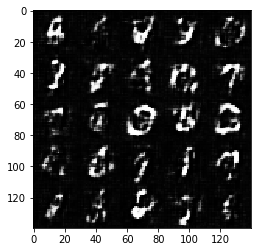

Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 1.0044
Epoch 1/2... Discriminator Loss: 0.8851... Generator Loss: 1.0149
Epoch 1/2... Discriminator Loss: 0.6583... Generator Loss: 1.8864
Epoch 1/2... Discriminator Loss: 0.6650... Generator Loss: 2.6251
Epoch 1/2... Discriminator Loss: 0.7371... Generator Loss: 2.7353
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 2.1506
Epoch 1/2... Discriminator Loss: 0.8558... Generator Loss: 2.1397
Epoch 1/2... Discriminator Loss: 0.6440... Generator Loss: 1.7700
Epoch 1/2... Discriminator Loss: 0.7593... Generator Loss: 1.3262
Epoch 1/2... Discriminator Loss: 0.6809... Generator Loss: 2.1683


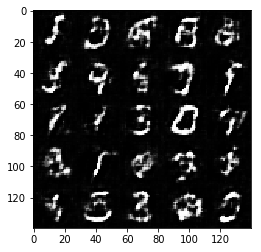

Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 0.7288... Generator Loss: 1.4705
Epoch 1/2... Discriminator Loss: 0.7664... Generator Loss: 1.4568
Epoch 1/2... Discriminator Loss: 0.6925... Generator Loss: 1.5259
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 0.8828... Generator Loss: 1.0441
Epoch 1/2... Discriminator Loss: 0.8916... Generator Loss: 1.7523
Epoch 1/2... Discriminator Loss: 0.7923... Generator Loss: 1.9179
Epoch 1/2... Discriminator Loss: 1.1088... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 0.7866


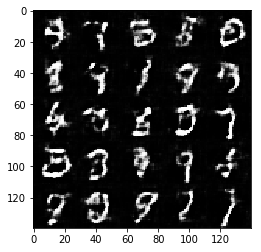

Epoch 1/2... Discriminator Loss: 0.8776... Generator Loss: 2.1225
Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 2.2433
Epoch 1/2... Discriminator Loss: 0.7653... Generator Loss: 1.4956
Epoch 1/2... Discriminator Loss: 0.8140... Generator Loss: 1.1724
Epoch 1/2... Discriminator Loss: 0.8424... Generator Loss: 1.1862
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 1.1593
Epoch 1/2... Discriminator Loss: 0.7639... Generator Loss: 1.3586
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 0.9943
Epoch 1/2... Discriminator Loss: 0.7940... Generator Loss: 1.4859
Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 0.7856


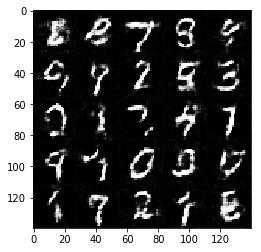

Epoch 1/2... Discriminator Loss: 0.8304... Generator Loss: 1.2975
Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 1.0031
Epoch 1/2... Discriminator Loss: 0.8084... Generator Loss: 1.2583
Epoch 2/2... Discriminator Loss: 0.8630... Generator Loss: 1.7969
Epoch 2/2... Discriminator Loss: 0.8313... Generator Loss: 1.1913
Epoch 2/2... Discriminator Loss: 0.8702... Generator Loss: 1.0491
Epoch 2/2... Discriminator Loss: 1.0006... Generator Loss: 0.9069
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 1.3663
Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 0.8421... Generator Loss: 1.2792


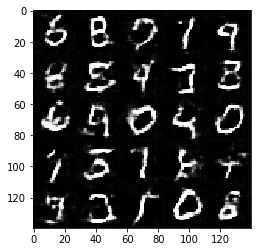

Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.4825
Epoch 2/2... Discriminator Loss: 0.7500... Generator Loss: 1.6346
Epoch 2/2... Discriminator Loss: 0.8233... Generator Loss: 1.2234
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 1.2177
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 0.7660... Generator Loss: 1.6297
Epoch 2/2... Discriminator Loss: 0.8026... Generator Loss: 2.2097
Epoch 2/2... Discriminator Loss: 1.1312... Generator Loss: 0.7502
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.1166
Epoch 2/2... Discriminator Loss: 0.8168... Generator Loss: 1.2342


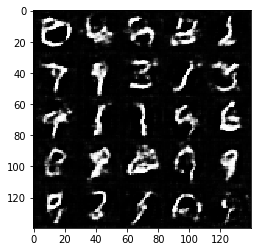

Epoch 2/2... Discriminator Loss: 0.9592... Generator Loss: 0.9872
Epoch 2/2... Discriminator Loss: 0.7611... Generator Loss: 1.5298
Epoch 2/2... Discriminator Loss: 0.7957... Generator Loss: 1.3413
Epoch 2/2... Discriminator Loss: 1.3446... Generator Loss: 0.5767
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 0.8185
Epoch 2/2... Discriminator Loss: 0.7490... Generator Loss: 1.3458
Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 1.3397
Epoch 2/2... Discriminator Loss: 0.7709... Generator Loss: 1.8563
Epoch 2/2... Discriminator Loss: 0.7678... Generator Loss: 1.6374
Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 2.5445


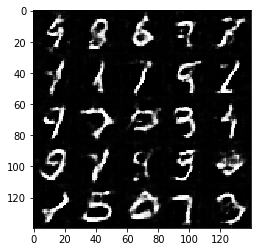

Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 1.9349
Epoch 2/2... Discriminator Loss: 0.8147... Generator Loss: 1.2938
Epoch 2/2... Discriminator Loss: 0.8659... Generator Loss: 1.0515
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 1.2910
Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 1.0145
Epoch 2/2... Discriminator Loss: 0.8124... Generator Loss: 1.2439
Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 1.4366
Epoch 2/2... Discriminator Loss: 0.9412... Generator Loss: 0.9156
Epoch 2/2... Discriminator Loss: 0.7741... Generator Loss: 1.2719
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.1574


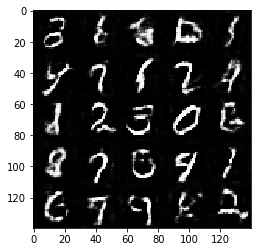

Epoch 2/2... Discriminator Loss: 0.9613... Generator Loss: 0.9379
Epoch 2/2... Discriminator Loss: 0.7409... Generator Loss: 1.3868
Epoch 2/2... Discriminator Loss: 0.8874... Generator Loss: 2.1640
Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.7766
Epoch 2/2... Discriminator Loss: 0.9084... Generator Loss: 1.5733
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 0.7506
Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 1.5992
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 1.6128
Epoch 2/2... Discriminator Loss: 0.7985... Generator Loss: 1.4625


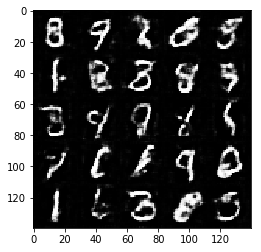

Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 1.5702
Epoch 2/2... Discriminator Loss: 0.8576... Generator Loss: 1.2663
Epoch 2/2... Discriminator Loss: 0.8810... Generator Loss: 1.8742
Epoch 2/2... Discriminator Loss: 1.0260... Generator Loss: 0.8781
Epoch 2/2... Discriminator Loss: 0.8661... Generator Loss: 1.1283
Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 1.4698
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.6390
Epoch 2/2... Discriminator Loss: 0.8370... Generator Loss: 1.1263
Epoch 2/2... Discriminator Loss: 0.7796... Generator Loss: 1.4389
Epoch 2/2... Discriminator Loss: 0.8467... Generator Loss: 1.2760


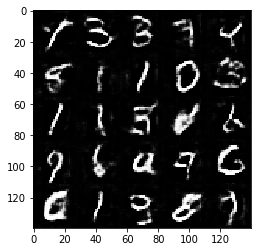

Epoch 2/2... Discriminator Loss: 1.0585... Generator Loss: 0.7840
Epoch 2/2... Discriminator Loss: 0.9175... Generator Loss: 2.0927
Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 1.7188
Epoch 2/2... Discriminator Loss: 0.8489... Generator Loss: 1.2453
Epoch 2/2... Discriminator Loss: 0.8883... Generator Loss: 1.0556
Epoch 2/2... Discriminator Loss: 0.9906... Generator Loss: 2.3296
Epoch 2/2... Discriminator Loss: 0.9467... Generator Loss: 0.9262
Epoch 2/2... Discriminator Loss: 0.7274... Generator Loss: 1.5408
Epoch 2/2... Discriminator Loss: 0.7147... Generator Loss: 1.8129
Epoch 2/2... Discriminator Loss: 0.8123... Generator Loss: 1.3773


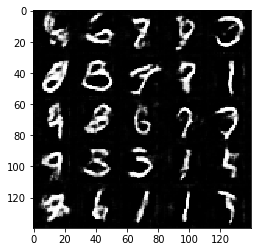

Epoch 2/2... Discriminator Loss: 0.9153... Generator Loss: 1.0460
Epoch 2/2... Discriminator Loss: 0.7557... Generator Loss: 1.7978
Epoch 2/2... Discriminator Loss: 0.7539... Generator Loss: 1.2926
Epoch 2/2... Discriminator Loss: 0.8664... Generator Loss: 1.1150
Epoch 2/2... Discriminator Loss: 0.7845... Generator Loss: 1.4401
Epoch 2/2... Discriminator Loss: 0.7611... Generator Loss: 1.5265
Epoch 2/2... Discriminator Loss: 0.7343... Generator Loss: 1.5128
Epoch 2/2... Discriminator Loss: 0.8638... Generator Loss: 1.9959
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 1.1517
Epoch 2/2... Discriminator Loss: 0.7088... Generator Loss: 1.8354


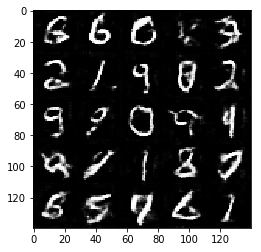

Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 0.7466
Epoch 2/2... Discriminator Loss: 0.6988... Generator Loss: 1.7072
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.2118
Epoch 2/2... Discriminator Loss: 0.9541... Generator Loss: 0.9446
Epoch 2/2... Discriminator Loss: 0.8600... Generator Loss: 1.3107
Epoch 2/2... Discriminator Loss: 0.7898... Generator Loss: 1.3019
Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 2.2464
Epoch 2/2... Discriminator Loss: 0.8515... Generator Loss: 1.0722
Epoch 2/2... Discriminator Loss: 0.9143... Generator Loss: 1.0479
Epoch 2/2... Discriminator Loss: 0.8275... Generator Loss: 1.1172


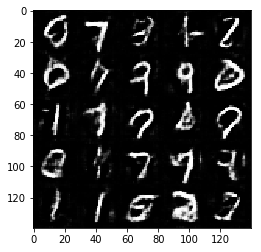

Epoch 2/2... Discriminator Loss: 0.8630... Generator Loss: 1.0949
Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 0.8112... Generator Loss: 1.7193
Epoch 2/2... Discriminator Loss: 0.7811... Generator Loss: 1.6067
Epoch 2/2... Discriminator Loss: 0.8461... Generator Loss: 1.1518
Epoch 2/2... Discriminator Loss: 0.9090... Generator Loss: 1.0188
Epoch 2/2... Discriminator Loss: 0.7215... Generator Loss: 1.8268


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.6839... Generator Loss: 0.1625
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.0308
Epoch 1/1... Discriminator Loss: 0.5764... Generator Loss: 2.5930
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.4400
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 2.1242
Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 5.4566
Epoch 1/1... Discriminator Loss: 0.5188... Generator Loss: 2.4160
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.6247
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 2.5921


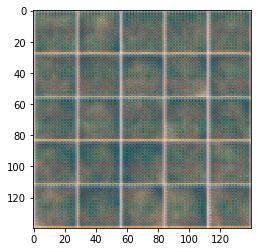

Epoch 1/1... Discriminator Loss: 1.7383... Generator Loss: 3.1801
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.2927
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 2.1259... Generator Loss: 0.4234
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.8419


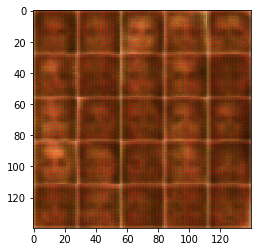

Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.2370
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 1.9014
Epoch 1/1... Discriminator Loss: 1.8901... Generator Loss: 0.3271
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.1442
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 1.8534
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.4198
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 1.4335
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.4981


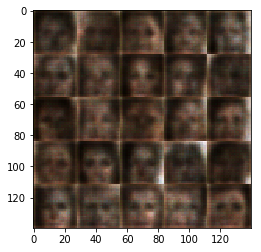

Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.6919... Generator Loss: 2.4172
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 1.3041
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.7091... Generator Loss: 1.6005
Epoch 1/1... Discriminator Loss: 1.7525... Generator Loss: 0.4014


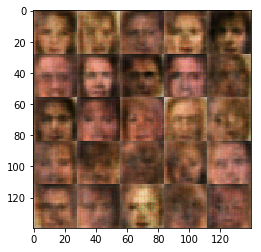

Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 2.3420
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 1.6632... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.6650


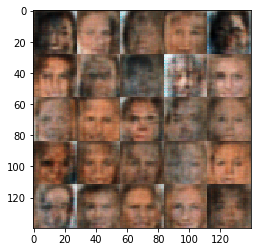

Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 1.7941
Epoch 1/1... Discriminator Loss: 1.6026... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.6849... Generator Loss: 0.3869
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 1.5655


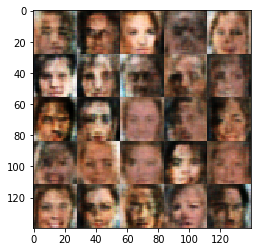

Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 1.3679


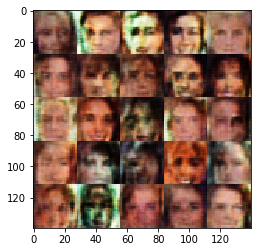

Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.4360
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.9422
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.7764


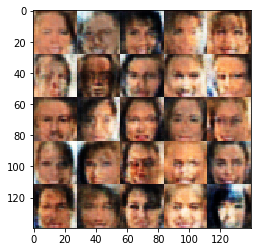

Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.5578


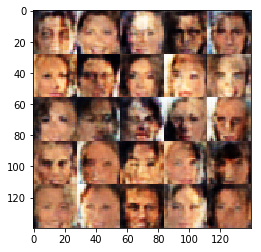

Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 1.3165
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 1.3287


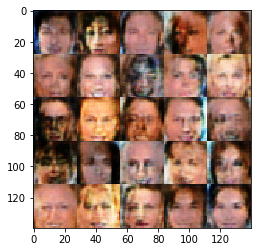

Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 1.1025
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 1.2148
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7834


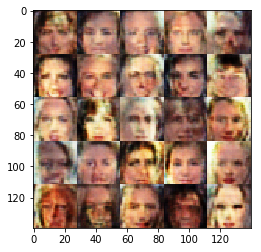

Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 1.0490
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.8381


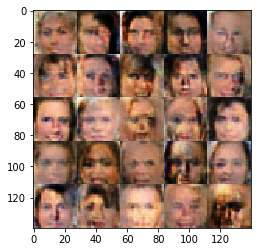

Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 1.6523
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.5427... Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.9043


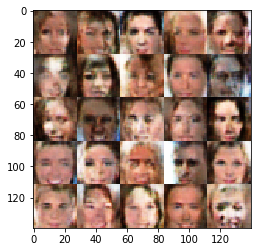

Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.3619
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.1434
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.5903


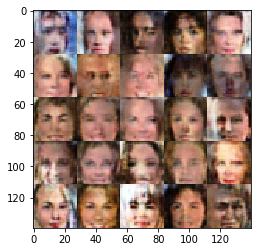

Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.9526


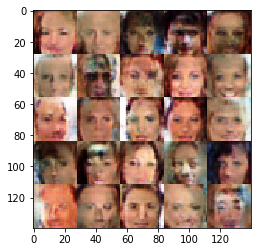

Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.1368
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.0628


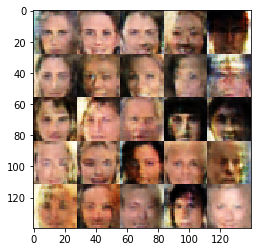

Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.7979


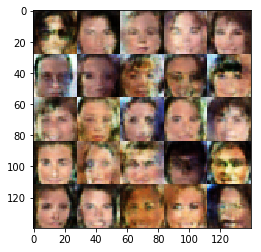

Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.1472
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.5175
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 1.1125


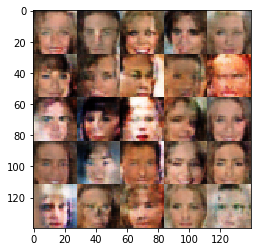

Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.4471
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.9627


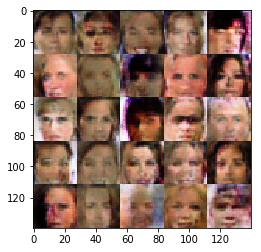

Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 1.1915
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.5781


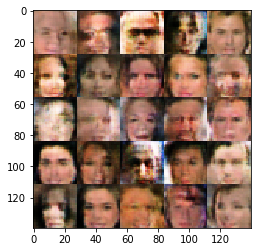

Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.7639... Generator Loss: 0.3486
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6288


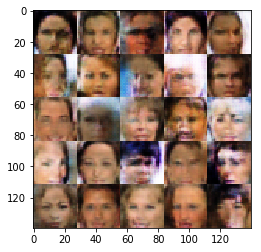

Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 1.6681... Generator Loss: 0.3537
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.9411


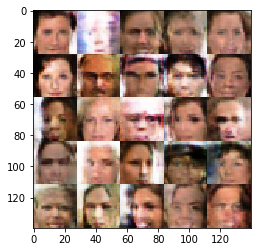

Epoch 1/1... Discriminator Loss: 1.5718... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.6266... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 1.4171
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.8779... Generator Loss: 0.2730
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.2386


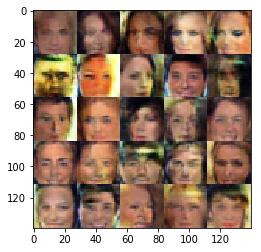

Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.6055


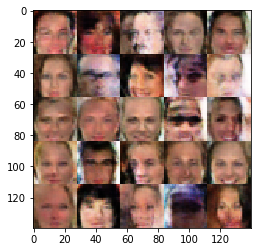

Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 1.6880... Generator Loss: 0.3710
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7125


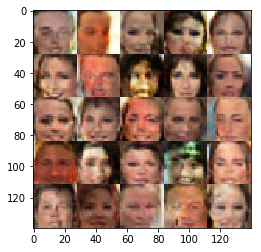

Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.1492
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.6818


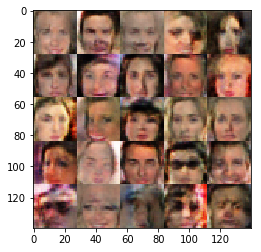

Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.2945
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.8332


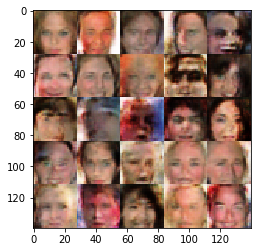

Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.6601
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.8340


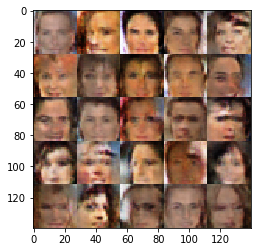

Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 1.1860
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.9438


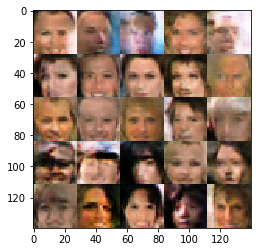

Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.6842... Generator Loss: 0.3595
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.7150


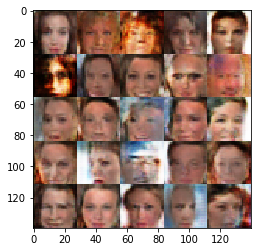

Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.1509


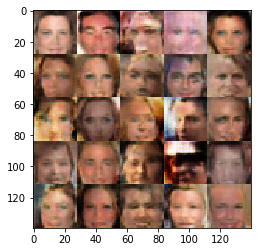

Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.4522


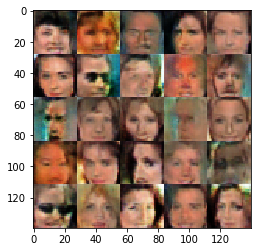

Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.5608... Generator Loss: 0.4940
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6363


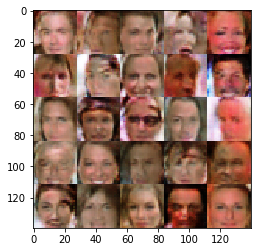

Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.4587
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.6361


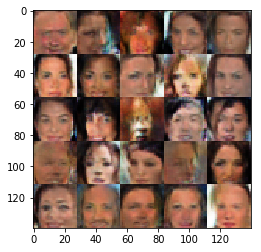

Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.1802
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.8001


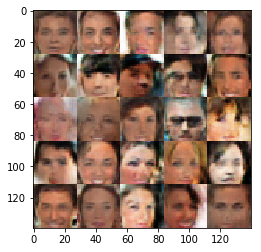

Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.5933... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.8000


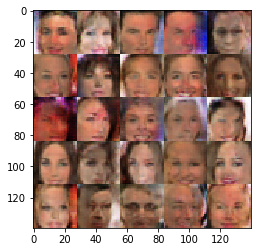

Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.4811
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.4999
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.1436


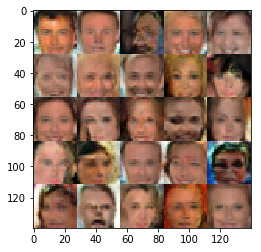

Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.8921


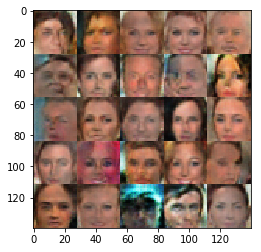

Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.9205


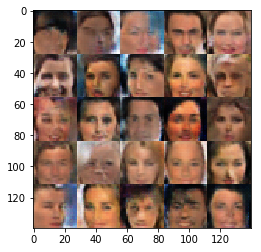

Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.2163
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.7000


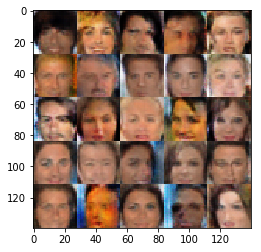

Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6136


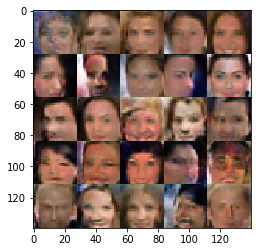

Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.0552
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.1601


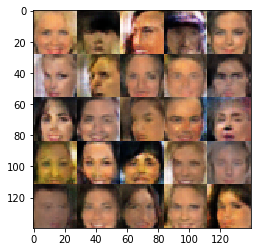

Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.4974
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.5440


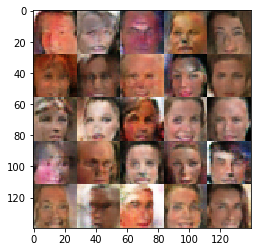

Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.4651
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.6691


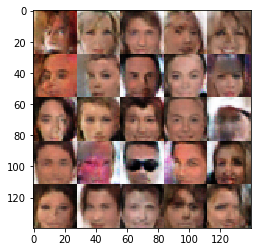

Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.5312


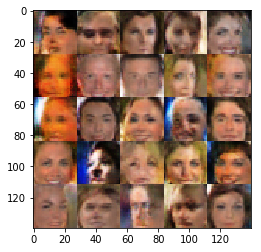

Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.6920


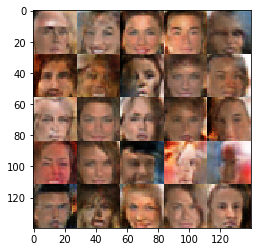

Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.7706


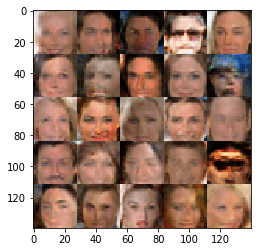

Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.8967


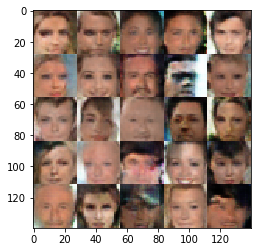

Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.6470... Generator Loss: 0.4062


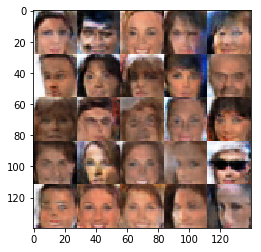

Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.6287


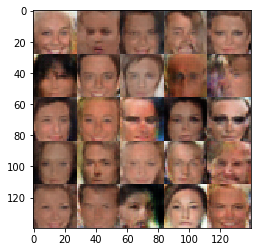

Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.6294... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 1.1455
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.6815


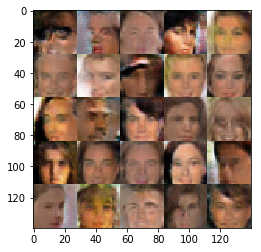

Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.4838
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.5976


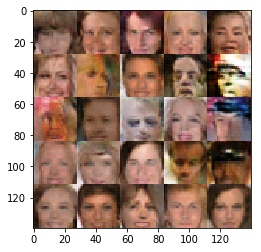

Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.5809


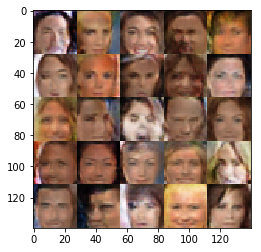

Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.5457


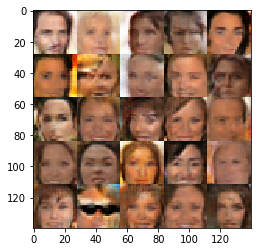

Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.7945


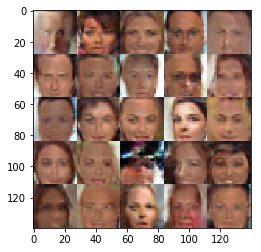

Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.6503... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6524


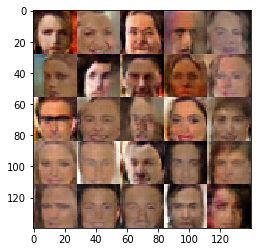

Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7439


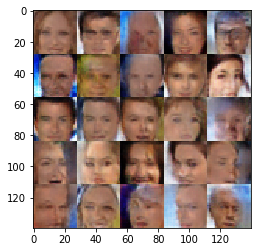

Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 1.1135
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.6282


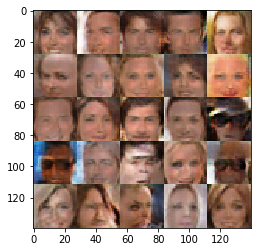

Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.9226


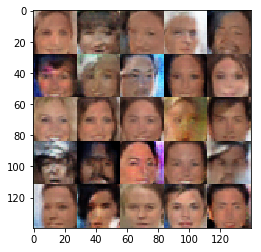

Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.7263... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.0753


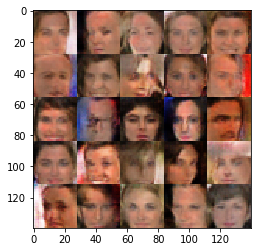

Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.8114


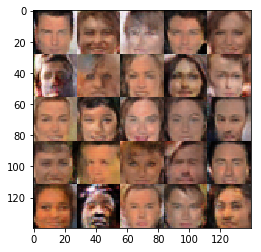

Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 1.8772... Generator Loss: 0.3258
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.7409... Generator Loss: 0.4127


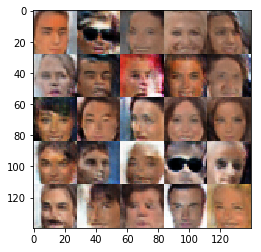

Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.5056
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.6078


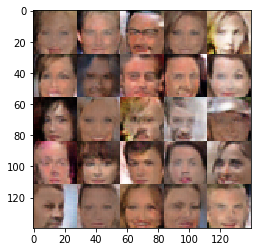

Epoch 1/1... Discriminator Loss: 1.5929... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 1.2407


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.